In [1]:
%%capture --no-display

import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# spectrome imports
from spectrome.brain import Brain
from spectrome.utils import functions, path
from spectrome.forward import eigenmode, get_complex_laplacian

# widget imports:
import nibabel as nib
from surfer import Brain as SB
from ipywidgets import interactive, widgets, fixed

## Examing and rendering brains for best eigenmode matches

In [2]:
%matplotlib inline

# House keeping
plt.style.use('seaborn')
data_dir = '../../data/'
hcp_dir = "../../data"


# Load Pablo's Yeo 2017 canonical network maps
com_dk = np.load(
    "../../data/com_dk.npy",
    allow_pickle = True
).item()
DK_df_normalized = pd.read_csv(
    "../../data/DK_dictionary_normalized.csv"
).set_index("Unnamed: 0")

# binarize:
ub, lb = 1, 0 #define binary boundaries

DKfc_binarized = pd.DataFrame(
    [], index=DK_df_normalized.index, columns=DK_df_normalized.columns
)
for name in DK_df_normalized.index:
    u = np.mean(np.nan_to_num(DK_df_normalized.loc[name].values))
    s = np.std(np.nan_to_num(DK_df_normalized.loc[name].values))
    threshold = u - s * 0.1
    DKfc_binarized.loc[name] = np.where(
        DK_df_normalized.loc[name].values > threshold, ub, lb
    )

#### Default network:

In [3]:
# load basin hopping results:
h5_path = path.get_file_path('Default_BH_dice.h5')
bh_default = path.read_hdf5(h5_path)
bh_default

{'lowest_optimization_result': {'hess_inv': array([[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1]]),
  'jac': array([0., 0., 0.]),
  'x': array([ 6.35167642,  7.82469652, -3.46317097]),
  'fun': 0.6694186046511628,
  'message': 'Optimization terminated successfully.',
  'nfev': 5,
  'nit': 0,
  'njev': 1,
  'status': 0,
  'success': True},
 'message': ['requested number of basinhopping iterations completed successfully'],
 'x': array([ 6.35167642,  7.82469652, -3.46317097]),
 'fun': 0.6694186046511628,
 'minimization_failures': 1,
 'nfev': 2887,
 'nit': 500,
 'njev': 575}

#### Dorsal attention network

In [4]:
# load results:
h5_path = path.get_file_path('Dorsal_Attention_BH_dice.h5')
bh_dorattn = path.read_hdf5(h5_path)
bh_dorattn

{'lowest_optimization_result': {'hess_inv': array([[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1]]),
  'jac': array([0., 0., 0.]),
  'x': array([ 2.62753374,  3.09871759, -0.03273678]),
  'fun': 0.8203953488372093,
  'message': 'Optimization terminated successfully.',
  'nfev': 30,
  'nit': 1,
  'njev': 6,
  'status': 0,
  'success': True},
 'message': ['requested number of basinhopping iterations completed successfully'],
 'x': array([ 2.62753374,  3.09871759, -0.03273678]),
 'fun': 0.8203953488372093,
 'minimization_failures': 0,
 'nfev': 2530,
 'nit': 500,
 'njev': 506}

#### Frontoparietal

In [5]:
h5_path = path.get_file_path('Frontoparietal_BH_dice.h5')
bh_ftpt = path.read_hdf5(h5_path)
bh_ftpt

{'lowest_optimization_result': {'hess_inv': array([[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1]]),
  'jac': array([0., 0., 0.]),
  'x': array([-0.47115614, -2.5191787 , 14.14344247]),
  'fun': 0.7265465116279068,
  'message': 'Optimization terminated successfully.',
  'nfev': 5,
  'nit': 0,
  'njev': 1,
  'status': 0,
  'success': True},
 'message': ['requested number of basinhopping iterations completed successfully'],
 'x': array([-0.47115614, -2.5191787 , 14.14344247]),
 'fun': 0.7265465116279068,
 'minimization_failures': 0,
 'nfev': 2505,
 'nit': 500,
 'njev': 501}

#### Limbic

In [6]:
h5_path = path.get_file_path('Limbic_BH_dice.h5')
bh_limb = path.read_hdf5(h5_path)
bh_limb

{'lowest_optimization_result': {'hess_inv': array([[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1]]),
  'jac': array([0., 0., 0.]),
  'x': array([4.53106719, 5.29513008, 8.17969248]),
  'fun': 0.6285348837209302,
  'message': 'Optimization terminated successfully.',
  'nfev': 5,
  'nit': 0,
  'njev': 1,
  'status': 0,
  'success': True},
 'message': ['requested number of basinhopping iterations completed successfully'],
 'x': array([4.53106719, 5.29513008, 8.17969248]),
 'fun': 0.6285348837209302,
 'minimization_failures': 0,
 'nfev': 2505,
 'nit': 500,
 'njev': 501}

Plot eigenmode dice dissimilarity scores:

mean dice dissimilarity score:  0.6285348837209302


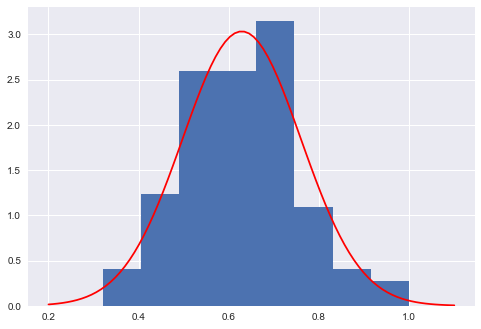

In [7]:
# Compute eigenmode dice with Brain:
limbic = Brain.Brain()
limbic.add_connectome(hcp_dir)
limbic.reorder_connectome(limbic.connectome, limbic.distance_matrix)
limbic.bi_symmetric_c()
limbic.reduce_extreme_dir()

# complex laplacian and its eigenmodes:
w = 2*np.pi*bh_limb['x'][0]
limbic.add_laplacian_eigenmodes(w, alpha = bh_limb['x'][1], speed = bh_limb['x'][2])

# binarize and compute dice:
limbic.binary_eigenmodes = np.where(limbic.norm_eigenmodes > 0.6, 1, 0)
limbic_dice = eigenmode.get_dice_df(limbic.binary_eigenmodes, DKfc_binarized)
# Compute mean Dice for chosen network:
dice_scores = np.round(limbic_dice['Limbic'].values.astype(np.double),3)
mean_dice = np.mean(dice_scores)
print("mean dice dissimilarity score: ", mean_dice)

# plot:
plt.figure('Limbic System')
plt.hist(dice_scores, bins = 8, density = True, histtype = 'bar')
xvals = plt.xticks()[0]
xmin, xmax = min(xvals), max(xvals)
xbins = np.linspace(xmin, xmax, len(dice_scores))
mu, sigma = stats.norm.fit(dice_scores)
gaussian_pdf = stats.norm.pdf(xbins, mu, sigma)
plt.plot(xbins, gaussian_pdf,'r', label = 'Gaussian Fit')

Render brain for best dice score:

In [34]:
%gui qt

# set up Pysurfer variables
subject_id = "fsaverage"
hemi = "split"
surf = "inflated"

"""
Bring up the visualization.
"""
#brain = Brain(subject_id, hemi , surf, background="white", views = ['lat','med'])
limb_SB = SB(subject_id, hemi, surf, background = "white", title = "Limbic freq = 4.5, alpha = 5.3, v = 8.2", views=['lat', 'med'])
#limb_SB.add_text(x = 0.5, y = 0.9, text = "Eig Number , frequency = , speed = ", name = "eiglabel")

"""
Read in the automatic parcellation of sulci and gyri.
"""

# left side:
hemi_side = "lh"
aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],
                          subject_id, "label",
                          hemi_side + ".aparc.annot")
labels, ctab, names = nib.freesurfer.read_annot(aparc_file)
lh_norm_eigs = limbic.norm_eigenmodes[:,np.argmin(dice_scores)]
lh_padded_eigs = np.insert(lh_norm_eigs, [0, 3], [0, 0])
limb_lh = lh_padded_eigs[labels]
limb_SB.add_data(limb_lh, hemi = 'lh', thresh = 0, colormap = "jet", remove_existing = True)

hemi_side = "rh"
aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],
                          subject_id, "label",
                          hemi_side + ".aparc.annot")
labels, ctab, names = nib.freesurfer.read_annot(aparc_file)

rh_norm_eigs = limbic.norm_eigenmodes[34:68,np.argmin(dice_scores)]
rh_padded_eigs = np.insert(rh_norm_eigs, [0,3],[0,0])
limb_rh = rh_padded_eigs[labels]
limb_SB.add_data(limb_rh, hemi = 'rh', thresh = 0, colormap = "jet", remove_existing = True)

colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
